In [1]:
# pip install transformers

In [2]:
# pip install emoji

### 1. import packages

In [3]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader
from transformers import AdamW
import pandas as pd
import torch
import random
import emoji
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import json
from collections import Counter
import logging
from string import punctuation
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO,filename='bert.log',filemode='w', format='%(asctime)s - %(message)s')

In [4]:
SEED = 9999
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

### 2.wordpiece

In [5]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

### 3.clean and load data

In [6]:
def remove_punc(string):
    punctuation_zh = r"""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~“”？，！【】（）、。：；’‘……￥·"""
    dicts = {i: '' for i in punctuation + punctuation_zh}
    dicts.pop('#')  # keep#
    punc_table = str.maketrans(dicts)
    return string.translate(punc_table)

In [7]:
def remove_emoji(string):
    allchars = [str for str in string]
    emoji_list = [c for c in allchars if c in emoji.UNICODE_EMOJI['en']]
    clean_text = ' '.join([str for str in string.split() if not any(i in str for i in emoji_list)])
    return clean_text

In [85]:
def read_data(file, test=False):
    texts = []
    labels = []
    data = pd.read_csv(file)
    if test == False:
        data.dropna(subset=['tidyTweet', 'Label'], inplace=True)
    else:
        data.dropna(subset=['tidyTweet'], inplace=True)
    for i in tqdm(data.itertuples(), total=len(data)):
        line = getattr(i, 'tidyTweet')
        line = line.strip()
        if not line:
            continue
        line = remove_emoji(line)
        line = remove_punc(line).strip()
        texts.append(line)
        if test == False:
            label = getattr(i, 'Label')
            labels.append(label)
            if label == 1.0:
                texts.extend([line] * 2)
                labels.extend([label] * 2)
    if test == False:
        assert len(texts) == len(labels)
        return texts, labels
    else:
        return texts

In [311]:
texts, labels = read_data('../dataset.csv')

  0%|          | 0/11747 [00:00<?, ?it/s]

In [87]:
Counter(labels)

Counter({0.0: 8864, 1.0: 8649})

### 4. seperate train set and val

In [11]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, stratify=labels, test_size=0.2, random_state=43)

In [12]:
len(train_labels),len(val_labels),len(train_texts),len(val_texts)

(14010, 3503, 14010, 3503)

### 5. check text and label

In [13]:
train_texts[:4]

['Hard to believe  finally found his missing balls WTF is so hard about condemning Nazis They actually chanted Putin Putin Putin Russia Russia Russia #Resist #maga  #MargIsANazi',
 'Lying about the RCMP lying about safe and effective EXPERIMENTAL mRNA gene therapy vaccine lying about dying with and from covid This has been one big coercive psychological operation #CrimesAgainstHumanity #NurembergTrialsForCovid #HonkHonk2022',
 '#antivaxxer your pathetic weasels bank on it with so much bullshit a verified ex York University TAspewing bullshit that her husband had a shop in the red zone no such thing and shesverified Question all these anti vaxxers its not the poison they say it is Its saved millions',
 'trump Wanted To Have The Pentagon Seize Voting Machines To Help Steal Election Yet MORE proof that trump was the one trying to rig the 2020 election which will be completely ignored by the rightwing news #trumpCrimeFamily']

In [14]:
train_labels[:4]

[0.0, 1.0, 0.0, 1.0]

### 6. calculate the maximum length

In [15]:
max_len = max([len(item) for item in train_texts])
print(max_len)

max_len = max([len(item) for item in val_texts])
print(max_len)

286
284


### 7. map between label and ID

In [16]:
label2id = {item: idx for idx, item in enumerate(set(sorted(labels)))}
id2label = {v: k for k, v in label2id.items()}

In [17]:
label2id,id2label

({0.0: 0, 1.0: 1}, {0: 0.0, 1: 1.0})

### 8.tokenization

In [18]:
train_encodings = tokenizer(train_texts,
                            truncation=True,
                            padding='max_length',
                            max_length=128)
val_encodings = tokenizer(val_texts,
                          truncation=True,
                          padding='max_length',
                          max_length=128)

### 9. generate Dataset

In [194]:
# PyTorch Dataset
class CuDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        idx = int(idx)
        item = {
            key: torch.tensor(val[idx])
            for key, val in self.encodings.items()
        }
        if self.labels is not None:
            item['labels'] = torch.tensor(label2id[self.labels[idx]])
        return item

    def __len__(self):
        return len(self.encodings.input_ids)

In [195]:
train_dataset = CuDataset(train_encodings, train_labels)
val_dataset = CuDataset(val_encodings, val_labels)

### 10.generate Dataloader

In [21]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
eval_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

### 11. load the model

In [22]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')  
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=len(label2id))
model.to(device)
model.train()

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

### 12.calculate Accuracy，Precision，Recall，F1 score

In [23]:
def compute_metrics(labels, preds):
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='macro')
    recall = recall_score(labels, preds, average='macro')
    f1 = f1_score(labels, preds, average='macro')
    logging.info(f'accuracy: {accuracy}')
    logging.info(f'precision: {precision}')
    logging.info(f'recall: {recall}')
    logging.info(f'f1: {f1}\n')
    return accuracy, precision, recall, f1

### 13. evaluate the model

In [24]:
@torch.no_grad()
def eval_model(model, eval_loader):
    model.eval()
    labels = []
    preds = []
    eval_loss = 0
    for idx, batch in enumerate(eval_loader):
        input_ids = batch['input_ids'].to(device)
        batch_labels = batch['labels'].to(device)
        labels.extend(batch['labels'].numpy())
        outputs = model(input_ids=input_ids, labels=batch_labels)
        loss = outputs.loss
        eval_loss += loss.item()
        preds.extend(torch.argmax(outputs.logits, dim=-1).cpu().numpy())
    accuracy, precision, recall, f1 = compute_metrics(labels, preds)
    eval_loss = eval_loss / len(val_dataset)
    model.train()
    return accuracy, precision, recall, f1, eval_loss

### 14. train the model

In [27]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [{
    'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
    'weight_decay_rate': 0.01
}, {
    'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
    'weight_decay_rate': 0.0
}]
lr = 1e-5
epoch = 10
path = 'model_best_bert'
best_acc = 0
train_losses = []
eval_stats = {'Epoch':[], 'Loss':[], 'Accuracy':[], 'Precision':[], 'Recall':[], 'F1':[]}
optim = AdamW(optimizer_grouped_parameters, lr=lr)
writer = SummaryWriter(
    comment='-bert-ep{}-bs{}-lr{}'
             .format(epoch, batch_size, lr)
)

for e in tqdm(range(epoch), desc='Epoch'):
    train_loss = 0
    for idx, batch in tqdm(enumerate(train_loader),
                           total=len(train_texts) // batch_size,
                           desc='Batch'):
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids=input_ids, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()

        loss.backward()
        optim.step()
    
    train_loss = train_loss / len(train_dataset)

    writer.add_scalar('train_loss', train_loss, e)
    logging.info(
        f'Epoch-{e}, Loss: {train_loss}')
    logging.info(
        f'Epoch {e}, present best acc: {best_acc}, start evaluating.')
    accuracy, precision, recall, f1, eval_loss = eval_model(model, eval_loader)
    train_losses.append(train_loss)
    eval_stats['Epoch'].append(e)
    eval_stats['Loss'].append(eval_loss)
    eval_stats['Accuracy'].append(accuracy)
    eval_stats['Precision'].append(precision)
    eval_stats['Recall'].append(recall)
    eval_stats['F1'].append(f1)
    writer.add_scalar('dev_accuracy', accuracy, e)
    writer.add_scalar('dev_precision', precision, e)
    writer.add_scalar('dev_recall', recall, e)
    writer.add_scalar('dev_f1', f1, e)
    print(f'Epoch:{e+1}/{epoch}')
    print('Train loss:', train_loss)
    print('Validation loss:', eval_loss)
    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1:', f1)
    if accuracy > best_acc:
        model.save_pretrained(path)
        tokenizer.save_pretrained(path)
        best_acc = accuracy
print('Finished Training.')

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/437 [00:00<?, ?it/s]

Epoch:1/10
Train loss: 0.010722570272852573
Validation loss: 0.011805636697144907
Accuracy: 0.851270339708821
Precision: 0.8512461688815057
Recall: 0.851286477639871
F1: 0.8512579273731794
Finished Training.


Batch:   0%|          | 0/437 [00:00<?, ?it/s]

Epoch:2/10
Train loss: 0.0069729289107774515
Validation loss: 0.00968085939254449
Accuracy: 0.8940907793320011
Precision: 0.897178883956256
Recall: 0.8946460882407598
F1: 0.8939663490937828
Finished Training.


Batch:   0%|          | 0/437 [00:00<?, ?it/s]

Epoch:3/10
Train loss: 0.004309510332342772
Validation loss: 0.010169759165158518
Accuracy: 0.9003711104767342
Precision: 0.9071691863793234
Recall: 0.9011797058641342
F1: 0.9000709081018738
Finished Training.


Batch:   0%|          | 0/437 [00:00<?, ?it/s]

Epoch:4/10
Train loss: 0.0028761524801474226
Validation loss: 0.010935187890121776
Accuracy: 0.8963745361119041
Precision: 0.9056190713929106
Recall: 0.8973157086548713
F1: 0.8959258752725157
Finished Training.


Batch:   0%|          | 0/437 [00:00<?, ?it/s]

Epoch:5/10
Train loss: 0.00216871279100359
Validation loss: 0.013123786760972136
Accuracy: 0.8918070225520982
Precision: 0.9040192370875492
Recall: 0.8928876956531662
F1: 0.891160424947834
Finished Training.


Batch:   0%|          | 0/437 [00:00<?, ?it/s]

Epoch:6/10
Train loss: 0.0015216043603697594
Validation loss: 0.008681012367254881
Accuracy: 0.9274907222380816
Precision: 0.9307548657944916
Recall: 0.9280475598981511
F1: 0.9274069483443051
Finished Training.


Batch:   0%|          | 0/437 [00:00<?, ?it/s]

Epoch:7/10
Train loss: 0.0012710981077642886
Validation loss: 0.014975376929125376
Accuracy: 0.8843848130174137
Precision: 0.9006266570747694
Recall: 0.8856325942444307
F1: 0.8834241243857275
Finished Training.


Batch:   0%|          | 0/437 [00:00<?, ?it/s]

Epoch:8/10
Train loss: 0.0010590753398056565
Validation loss: 0.011566130753873485
Accuracy: 0.9120753639737368
Precision: 0.9208530016824412
Recall: 0.9129803507330576
F1: 0.9117303638176011
Finished Training.


Batch:   0%|          | 0/437 [00:00<?, ?it/s]

Epoch:9/10
Train loss: 0.0007627186893823183
Validation loss: 0.01430332538018563
Accuracy: 0.9057950328290038
Precision: 0.9169992868605221
Recall: 0.9068182336851096
F1: 0.9053010567707054
Finished Training.


Batch:   0%|          | 0/437 [00:00<?, ?it/s]

Epoch:10/10
Train loss: 0.0007586327770189432
Validation loss: 0.012354091516755204
Accuracy: 0.9149300599486154
Precision: 0.9230648154229618
Recall: 0.9158004296952684
F1: 0.914626155444591
Finished Training.


In [38]:
train_losses

[0.010722570272852573,
 0.0069729289107774515,
 0.004309510332342772,
 0.0028761524801474226,
 0.00216871279100359,
 0.0015216043603697594,
 0.0012710981077642886,
 0.0010590753398056565,
 0.0007627186893823183,
 0.0007586327770189432]

In [37]:
eval_stats

{'Accuracy': [0.851270339708821,
  0.8940907793320011,
  0.9003711104767342,
  0.8963745361119041,
  0.8918070225520982,
  0.9274907222380816,
  0.8843848130174137,
  0.9120753639737368,
  0.9057950328290038,
  0.9149300599486154],
 'Epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 'F1': [0.8512579273731794,
  0.8939663490937828,
  0.9000709081018738,
  0.8959258752725157,
  0.891160424947834,
  0.9274069483443051,
  0.8834241243857275,
  0.9117303638176011,
  0.9053010567707054,
  0.914626155444591],
 'Loss': [0.011805636697144907,
  0.00968085939254449,
  0.010169759165158518,
  0.010935187890121776,
  0.013123786760972136,
  0.008681012367254881,
  0.014975376929125376,
  0.011566130753873485,
  0.01430332538018563,
  0.012354091516755204],
 'Precision': [0.8512461688815057,
  0.897178883956256,
  0.9071691863793234,
  0.9056190713929106,
  0.9040192370875492,
  0.9307548657944916,
  0.9006266570747694,
  0.9208530016824412,
  0.9169992868605221,
  0.9230648154229618],
 'Recall': [0.8512864

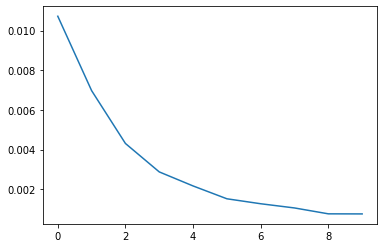

In [44]:
plt.plot(train_losses)
plt.show()

In [ ]:
# from google.colab import files

# !zip -r /content/model_best_bert.zip /content/model_best_bert
# files.download("/content/model_best_bert.zip")

# !zip -r /content/runs.zip /content/runs
# files.download("/content/runs.zip")

# files.download("/content/bert.log")

###15. prediction of test dataset

In [259]:
trained_bert_model = BertForSequenceClassification.from_pretrained(path)
trained_bert_tokenizer = BertTokenizer.from_pretrained(path)
trained_bert_model.to(device)

In [321]:
test_texts = read_data('../test_truckers_data.csv', test=True)
test_encodings = trained_bert_tokenizer(test_texts,
                          truncation=True,
                          padding='max_length',
                          max_length=128)
test_dataset = CuDataset(test_encodings)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  0%|          | 0/1803 [00:00<?, ?it/s]

In [ ]:
@torch.no_grad()
def test_model(model, test_loader):
    model.eval()
    preds = []
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        outputs = model(input_ids)
        preds.extend(torch.argmax(outputs.logits, dim=-1).cpu().numpy())
    return preds

In [ ]:
test_predictions = test_model(trained_bert_model, test_loader)

In [ ]:
np.unique(test_predictions, return_counts=True)